In [1]:
# import necessary libraries
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np

/Users/sabbirahmad/CSE425_Project/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from torchvision import datasets

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.43MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 71.4kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 448kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.28MB/s]


In [11]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [12]:
# Train the Autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        batch = batch[0].to(device)
        output = model(batch)
        loss = criterion(output, batch.view(batch.size(0), -1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/5, Loss: 61.6970
Epoch 2/5, Loss: 25.2483
Epoch 3/5, Loss: 19.7420
Epoch 4/5, Loss: 17.1705
Epoch 5/5, Loss: 15.4378


In [13]:
model.eval()
embeddings = []

with torch.no_grad():
    for batch in train_loader:
        images, _ = batch              
        images = images.to(device)
        z = model.encoder(images)   
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)
print("Embedding shape:", embeddings.shape)


Embedding shape: (60000, 64)


In [14]:
# Applied K-Means and Evaluate
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings)
labels = kmeans.labels_
score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.0884


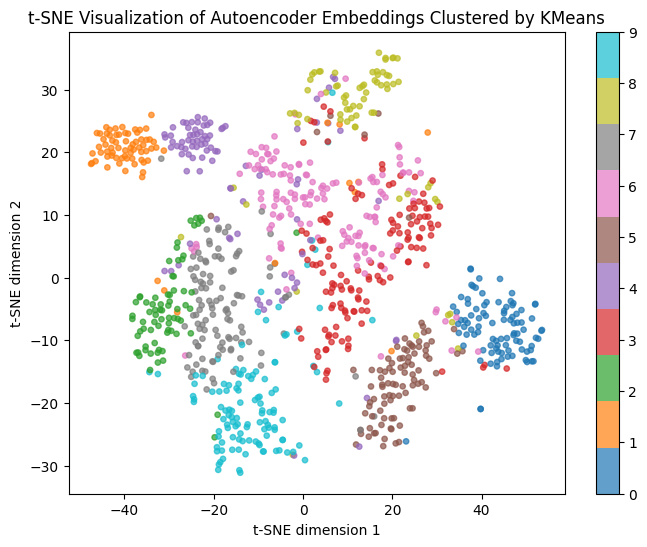

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Used a subset (like first 1000) for speed and clarity
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
reduced = tsne.fit_transform(embeddings[:1000])
clusters = labels[:1000]

plt.figure(figsize=(8,6))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap='tab10', s=15, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE Visualization of Autoencoder Embeddings Clustered by KMeans")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()


In [16]:
# tried DBSCAN Clustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Tried DBSCAN on the same embeddings
dbscan = DBSCAN(eps=3, min_samples=5) 
db_labels = dbscan.fit_predict(embeddings)

# Some labels might be -1 (noise), so we check how many clusters were formed
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"DBSCAN Clusters (excluding noise): {n_clusters}")

# Calculate Silhouette Score
if n_clusters > 1:
    filtered_embeddings = embeddings[db_labels != -1]
    filtered_labels = db_labels[db_labels != -1]
    score = silhouette_score(filtered_embeddings, filtered_labels)
    print(f"Silhouette Score (DBSCAN): {score:.4f}")
else:
    print("DBSCAN found too few clusters for Silhouette Score.")


DBSCAN Clusters (excluding noise): 18
Silhouette Score (DBSCAN): -0.4225
